# Avocado Prices (2018) 

![avocado](https://www.californiaavocado.com/wp-content/uploads/2020/08/19-11090725_Label_Update_HASS_r01-4046-2.png)

Dataset is taken from [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices), which provides data from the (Hass Avocado Board)[https://hassavocadoboard.com/]'s website in 2018.

The Hass Avocado Board describes the data with the following description:

>The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

PLU lookup for avocados are found on (this website)[https://californiaavocado.com/retail/avocado-plus/]:
* `4046` - Hass, Small; #60 size and smaller
* `4225` - Hass, Large; #40 & #48 sizes
* `4770` - Hass, Extra Large; #36 and larger

In [148]:
# Import libraries
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
plt.style.use('sg')

from mapboxgl.utils import *
from mapboxgl.viz import *

In [114]:
# Read data
df = pd.read_csv("avocado.csv", index_col=0)

df.head(2)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany


In [121]:
# Rename columns 
df.rename(columns={"4046": "plu_4046", "4225": "plu_4225", "4770": "plu_4770", "averageprice": "average_price"},  inplace=True)
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Cast as datetime
df.date = pd.to_datetime(df.date)

In [129]:
# Create date columns
df["year"] = pd.DatetimeIndex(df['date']).year.astype(int)
df["month"] = pd.DatetimeIndex(df['date']).month.astype(int)

## Nation-level Analysis

In [130]:
# Filter to U.S. "region" - assuming this is an aggregate of the nation
df_us = df[df.region == 'TotalUS']
df_us = df_us.sort_values(by="date")

### What is the product mix?

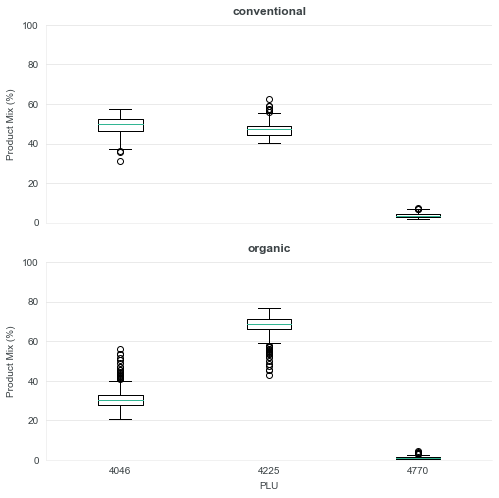

In [252]:
# Plot share by product
types = list(df_us.type.unique())

fig = plt.figure(figsize=[8,8])
for i, t in enumerate(types):
    ax = fig.add_subplot(2, 1, i+1)
    
    df_us_type = df_us[df_us.type == t]

    plu_4046 = df_us_type.plu_4046 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100
    plu_4225 = df_us_type.plu_4225 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100
    plu_4770 = df_us_type.plu_4770 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100

    data = [plu_4046, plu_4225, plu_4770]

    ax.boxplot(data)

    

    ax.set_title(t)
    ax.set_ylabel('Product Mix (%)')
    ax.set_ylim([0,100])
    ax.set_xticks([], [])
    
ax.set_xlabel('PLU')
plt.xticks([1, 2, 3], ['4046', '4225', '4770']);

/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


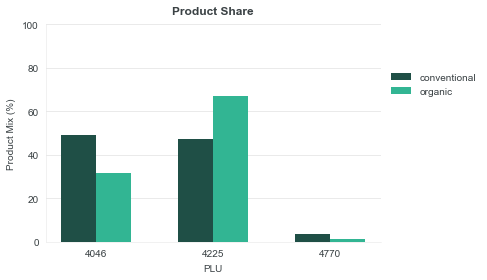

In [286]:
# Plot share by product
types = list(df_us.type.unique())

fig = plt.figure()
for i, t in enumerate(types):
    ax = fig.add_subplot(111)
    
    df_us_type = df_us[df_us.type == t]

    plu_4046 = np.mean(df_us_type.plu_4046 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100)
    plu_4225 = np.mean(df_us_type.plu_4225 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100)
    plu_4770 = np.mean(df_us_type.plu_4770 / (df_us_type.plu_4046 + df_us_type.plu_4225 + df_us_type.plu_4770) * 100)

    labels = [0, 1, 2]
    heights = [plu_4046, plu_4225, plu_4770]

    ax.bar([l + i%2*.3 for l in labels], heights, width=0.3)

ax.set_title("Product Share")
ax.set_ylabel('Product Mix (%)')
ax.set_xlabel('PLU')
ax.set_ylim([0,100])
plt.xticks([0.15, 1.15, 2.15], ['4046', '4225', '4770'])
ax.legend(types, loc=(1.02, 0.65));

In [290]:
# Total units (in millions)
df_us.groupby("type").sum()[["plu_4046","plu_4225","plu_4770"]]/1000000

,plu_4046,plu_4225,plu_4770
type,,,
conventional,2029.855843,1962.911487,155.260970
organic,25.080389,52.100068,0.914213


### What is the average price over time?

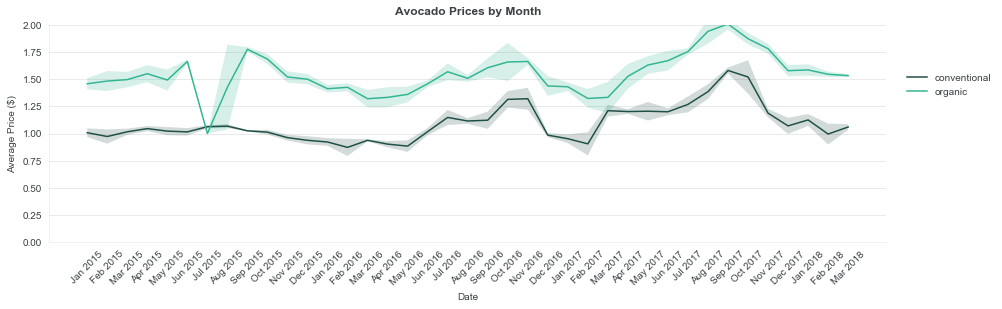

In [224]:
# Plot monthly
types = list(df_us.type.unique())

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for t in types:
    
    df_us_month = df_us[df_us.type == t]
    df_us_month = df_us_month.groupby(["year","month"]).agg({"average_price":["mean", "std"]}).average_price.reset_index()
    df_us_month["date"] = df_us_month.apply(lambda x: 
                                        datetime.datetime.strptime(str(int(x.month)), "%m").strftime("%b") 
                                        + " " 
                                        + str(int(x.year)), axis=1
                                       )
    
    
    ax.plot(df_us_month.date, df_us_month["mean"])
    ax.fill_between(df_us_month.date, df_us_month["mean"] - df_us_month["std"], df_us_month["mean"] + df_us_month["std"], alpha=0.2)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_ylim([0,2])
ax.set_title("Avocado Prices by Month")
ax.set_xlabel('Date')
ax.set_ylabel('Average Price ($)')
ax.legend(types, loc=(1.02, 0.65));

/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


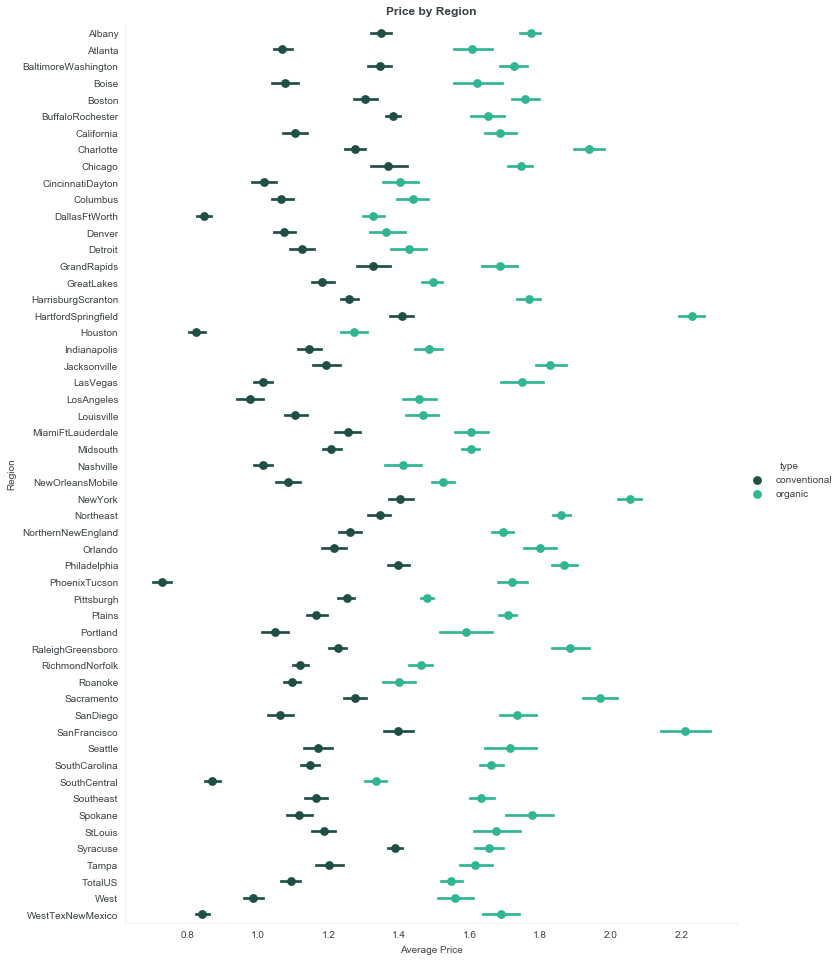

In [307]:
import seaborn as sns

g = sns.factorplot('average_price','region',data=df,
                   hue='type',
                   alpha=0.2,
                   size=13,
                   aspect=0.8,
                   join=False,
              )

plt.xlabel("Average Price")
plt.ylabel("Region")
plt.title("Price by Region");